In [142]:
import matplotlib.pyplot as plt
from scipy import optimize
import numpy as np
import sympy as sm
import func
import time
%load_ext line_profiler
%reload_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [145]:
def utility(c,theta):
    ''' Utility function for consumption including the limit case for rho->1 '''
    if c<0:
        raise error
    if rho !=1 :
        return (c**(1-theta)-1)/(1-theta)
    else:
        return np.log(c)

def total_utility(c, beta, theta, k):
    '''
    Sums utility for c for multiple years
    c is an array 
    '''
    t_u = 0
    for i,ct in enumerate(c):
        t_u += beta**i*utility(ct,theta)
    t_u += beta**(len(c))*utility(k,theta)
    return t_u

def prod(k,l,alpha,b):
    return b*k**alpha*l**(1-alpha)

In [251]:
def tot_ut2(c, beta, theta, k):
    t_u = 0
    for i in range(len(c)):
        t_u += beta**i*utility(c[i],theta)
    t_u += beta**(len(c))*utility(k,theta)
    return t_u

In [265]:
%lprun -f tot_ut2 tot_ut2(c, beta, theta, k)

Timer unit: 1e-06 s

Total time: 0.000715 s
File: <ipython-input-251-506b471cc1b3>
Function: tot_ut2 at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def tot_ut2(c, beta, theta, k):
     2         1          4.0      4.0      0.6      t_u = 0
     3       101        116.0      1.1     16.2      for i in range(len(c)):
     4       100        589.0      5.9     82.4          t_u += beta**i*utility(c[i],theta)
     5         1          5.0      5.0      0.7      t_u += beta**(len(c))*utility(k,theta)
     6         1          1.0      1.0      0.1      return t_u

In [270]:
%lprun -f total_utility total_utility(c, beta, theta, k)

Timer unit: 1e-06 s

Total time: 0.001086 s
File: <ipython-input-145-fa141ec671e5>
Function: total_utility at line 10

Line #      Hits         Time  Per Hit   % Time  Line Contents
    10                                           def total_utility(c, beta, theta, k):
    11                                               '''
    12                                               Sums utility for c for multiple years
    13                                               c is an array 
    14                                               '''
    15         1          3.0      3.0      0.3      t_u = 0
    16       101        233.0      2.3     21.5      for i,ct in enumerate(c):
    17       100        837.0      8.4     77.1          t_u += beta**i*utility(ct,theta)
    18         1         12.0     12.0      1.1      t_u += beta**(len(c))*utility(ct,theta)
    19         1          1.0      1.0      0.1      return t_u

# Fast opsparingsrate

In [4]:
theta = 0.5
alpha = 1/3
delta = 0.05
rho = 0.5

In [5]:
t = 1000
b = 10
k0 = 10
l = 1
beta = 0.9

In [6]:
n = 100
ks = np.linspace(0.1,200,n)
sks = np.zeros(n)
for i,k in enumerate(ks):
    sks[i] = opt_sk(t, b, beta,delta,alpha,theta,k)

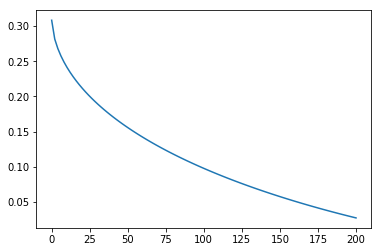

In [7]:
func.plot(ks,sks)

# Varierende opsparingsrate

In [120]:
def tot_ut_multiple_sks(sks, k0, l, b, beta, theta, alpha, delta, vector=False):
    '''
    Finds total utitilty for a set of years with a savingsrate for each year
    '''
    t = len(sks)
    k_short = np.empty(t)
    k_short[0] = k0
    
    for i in range(1,t):    
        k_short[i]=sks[i-1]*prod(k_short[i-1],l,alpha,b)+(1-delta)*k_short[i-1]
    y_short = [prod(k,l,alpha,b) for k in k_short]
    if vector==False:
        return total_utility(y_short*(1-sks), beta, theta, k_short[-1])
    elif vector==True:
        return total_utility(y_short*(1-sks), beta, theta, k_short[-1]), y_short, y_short*(1-sks), k_short

In [75]:
theta = 0.9
alpha = 1/3
delta = 0.05
beta = 1
b = 10
k0 = 1
l = 10

In [90]:
t = 50
obj = lambda sks: -tot_ut_multiple_sks(sks, k0, l, b, beta, theta, alpha, delta)
sks0 = np.full(t,0.3)
sks0[-1] = 0
bounds = np.full((t,2),[0,1])


res = optimize.minimize(obj, sks0, method='SLSQP', bounds=bounds)

print(f'Optimal sk')
np.set_printoptions(precision=4,suppress=True)
print(res.x)
print('Total utility:')
print(f'{-res.fun:.4f}')

Optimal sk
[0.6152 0.6445 0.6292 0.605  0.581  0.5585 0.538  0.5191 0.5016 0.4854
 0.4702 0.456  0.4425 0.4295 0.4172 0.4052 0.3936 0.3821 0.3708 0.3597
 0.3484 0.3371 0.3256 0.3138 0.3017 0.2891 0.276  0.2621 0.2472 0.2313
 0.2141 0.1954 0.1748 0.1519 0.1262 0.097  0.0636 0.0247 0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
Total utility:
414.7627


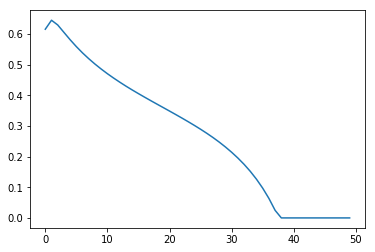

In [91]:
func.plot(range(t),res.x)

In [110]:
def optimal_sks(t, b, l, beta, delta, alpha, theta, k0, first=True):
    obj = lambda sks: -tot_ut_multiple_sks(sks, k0, l, b, beta, theta, alpha, delta)
    sks0 = np.full(t,0.3)
    sks0[-1] = 0
    bounds = np.full((t,2),[0,1])
    res = optimize.minimize(obj, sks0, method='SLSQP', bounds=bounds)
    if res.success == False:
        print('Optimization was sadly not succesfull')
    elif first:
        return res.x[0]
    else:
        return res.x

In [122]:
theta = 0.9
alpha = 1/3
delta = 0.05
beta = 1
b = 2
beta = 0.99
k0 = 40
l = 1
t = 100

In [123]:
sks = optimal_sks(t, b, l, beta, delta, alpha, theta, k0, first=False)
total, y, c, k = tot_ut_multiple_sks(sks, k0, l, b, beta, theta, alpha, delta, vector=True)

In [128]:
sks_alt = np.array([alpha for i in list(range(t))])
total_alt, y_alt, c_alt, k_alt = tot_ut_multiple_sks(sks_alt, k0, l, b, beta, theta, alpha, delta, vector=True)

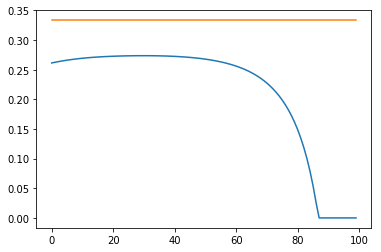

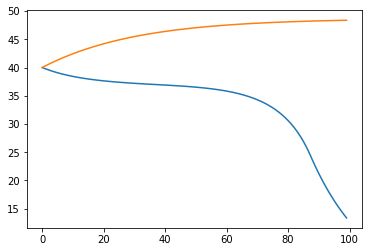

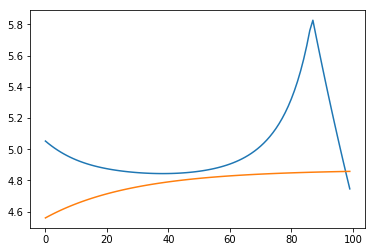

In [130]:
func.plot2(range(t),sks,sks_alt)
func.plot2(range(t),k,k_alt)
func.plot2(range(t),c,c_alt)

In [133]:
ks = np.linspace(0.1,100,100)
sks1 = np.empty(100)

for i, k in enumerate(ks):
    sks1[i] = optimal_sks(t, b, l, beta, delta, alpha, theta, k)

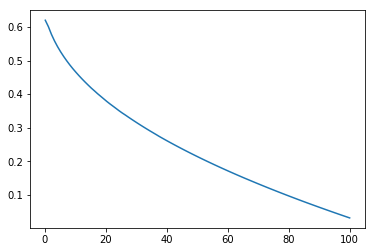

In [134]:
func.plot(ks,sks1)

In [21]:
ks = np.linspace(1,600,50)
sks1 = np.empty(50)

for i, k in enumerate(ks):
    sks1[i] = optimal_sks(t, b, beta, delta, alpha, theta, k)

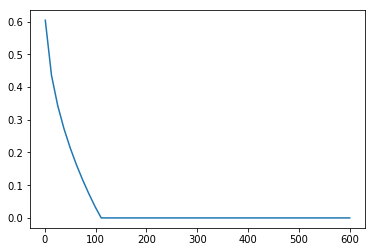

In [22]:
func.plot(ks,sks1)

# Need for speed

In [137]:
%time sk = optimal_sks(t, b, l, beta, delta, alpha, theta, k0)

CPU times: user 505 ms, sys: 13.1 ms, total: 518 ms
Wall time: 506 ms


In [138]:
%lprun -f tot_ut_multiple_sks -f optimal_sks optimal_sks(t, b, l, beta, delta, alpha, theta, k0)

Timer unit: 1e-06 s

Total time: 1.06284 s
File: <ipython-input-110-782af4b0fee0>
Function: optimal_sks at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def optimal_sks(t, b, l, beta, delta, alpha, theta, k0, first=True):
     2         1          3.0      3.0      0.0      obj = lambda sks: -tot_ut_multiple_sks(sks, k0, l, b, beta, theta, alpha, delta)
     3         1         26.0     26.0      0.0      sks0 = np.full(t,0.3)
     4         1          2.0      2.0      0.0      sks0[-1] = 0
     5         1         27.0     27.0      0.0      bounds = np.full((t,2),[0,1])
     6         1    1062762.0 1062762.0    100.0      res = optimize.minimize(obj, sks0, method='SLSQP', bounds=bounds)
     7         1         14.0     14.0      0.0      if res.success == False:
     8                                                   print('Optimization was sadly not succesfull')
     9         1          1.0      1.0      